In [95]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats as st
import cartopy.crs as ccrs
import pymannkendall as mk
import cartopy.feature as cfeature

In [103]:
dataset_path = "data\cdf\Monthly.v3.1-19930101-20231231.nc"
data = xr.open_dataset(dataset_path)

In [119]:
list(data.variables)

['lat', 'lon', 'time', 'rfe', 'rfe_filled']

In [120]:
# ds_pr=data['rfe'].groupby('time.year').mean('time')

In [121]:
ds_pr = data['rfe']

In [122]:
def spi(ds, thresh, dimension):
    #ds - data ; thresh - time interval / scale; dimension - dimension as a string
    
    #Rolling Mean / Moving Averages
    ds_ma = ds.rolling(time=thresh, center=False).mean(dimension)

    #Natural log of moving averages
    ds_In = np.log(ds_ma)
    ds_In = ds_In.where(np.isinf(ds_In) == False) #= np.nan  #Change infinity to NaN
    
    ds_mu = ds_ma.mean(dimension)
    
    #Overall Mean of Moving Averages
    ds_mu = ds_ma.mean(dimension)
    
    #Summation of Natural log of moving averages
    ds_sum = ds_In.sum(dimension)
    
    #Computing essentials for gamma distribution
    n = ds_In[thresh-1:, :, :].count(dimension)                  #size of data
    A = np.log(ds_mu) - (ds_sum/n)             #Computing A
    alpha = (1/(4*A))*(1+(1+((4*A)/3))**0.5)   #Computing alpha  (a)
    beta = ds_mu/alpha                         #Computing beta (scale)
    
    #Gamma Distribution (CDF)
    gamma_func = lambda data, a, scale: st.gamma.cdf(data, a=a, scale=scale)
    gamma = xr.apply_ufunc(gamma_func, ds_ma, alpha, beta)
    
    #Standardized Precipitation Index   (Inverse of CDF)
    norminv = lambda data: st.norm.ppf(data, loc=0, scale=1)
    norm_spi = xr.apply_ufunc(norminv, gamma)  #loc is mean and scale is standard dev.
    
    return ds_ma, ds_In , ds_mu, ds_sum,n, A, alpha, beta, gamma, norm_spi

In [123]:
i=12
data['spi_12'] = spi(ds_pr, i, 'time')[9]

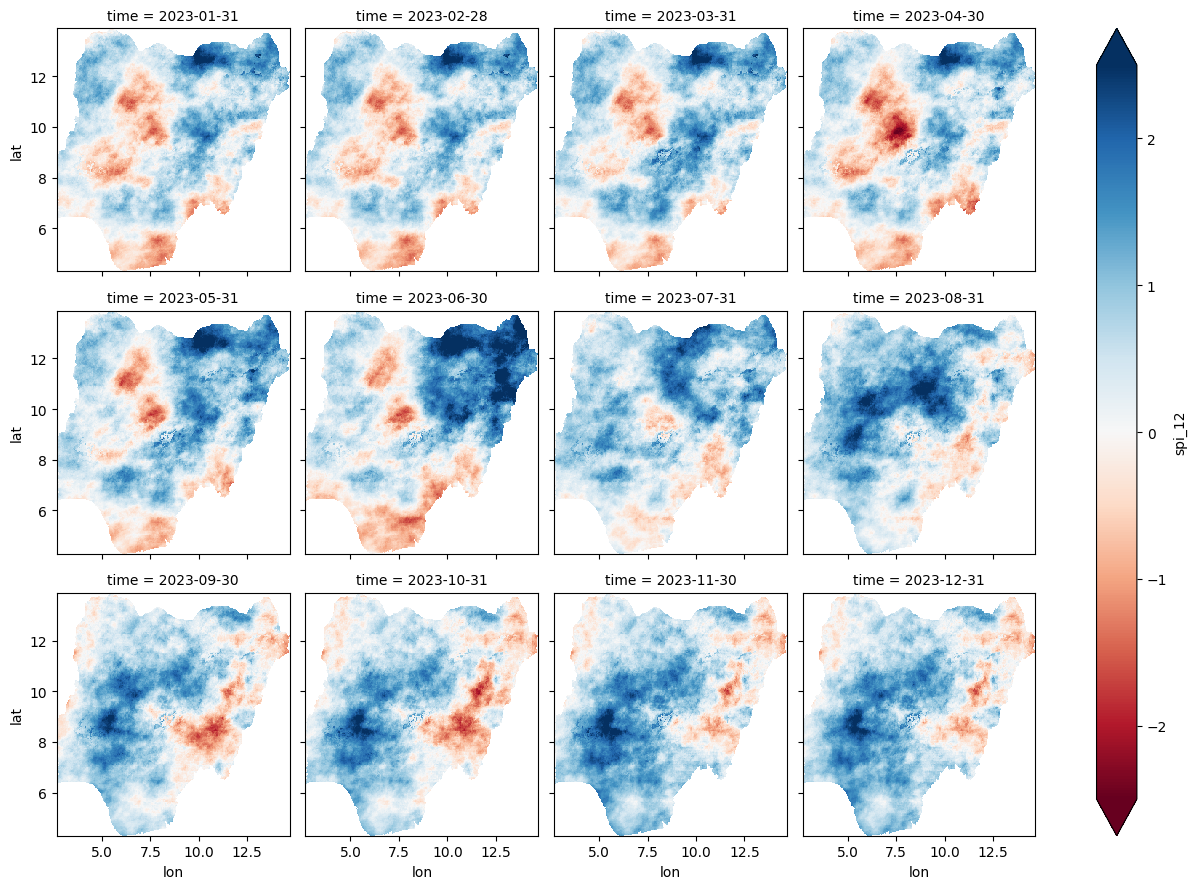

In [124]:
data['spi_12'].sel(time='2023').plot(cmap='RdBu', col='time', col_wrap=4, vmin=-2.5, vmax=2.5)